In [2]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Flatten, Dropout, Reshape
from keras.layers import Conv2D, LSTM, Embedding, Bidirectional, Input, merge, multiply, concatenate
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical
from keras import regularizers
from keras.models import Model

ImportError: No module named sklearn.model_selection

In [2]:
with open('dataset/PELM/fixed_sequences_length_9/Group_Phos_Y_neg.fasta', 'r') as f:
    s_negatif_txt = f.readlines()

s_negatif = np.array([])
for i in range(1,len(s_negatif_txt),2):
    temp = s_negatif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    s_negatif = np.append(s_negatif, temp2)

sequenceL = int(len(s_negatif)/9)
s_negatif_new = np.expand_dims(s_negatif, axis=0)
s_negatif_new = s_negatif_new.reshape(sequenceL,9)
labelneg = np.zeros((sequenceL,), dtype=int)
s_negatif_label = np.expand_dims(labelneg, axis=0)
s_negatif_label = s_negatif_label.reshape(sequenceL,1)
print(s_negatif_new.shape)
print(s_negatif_label.shape)


(226, 9)
(226, 1)


In [3]:
with open('dataset/PELM/fixed_sequences_length_9/Group_Phos_Y_pos.fasta', 'r') as f:
    s_positif_txt = f.readlines()

s_positif = np.array([])
for i in range(1,len(s_positif_txt),2):
    temp = s_positif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    s_positif = np.append(s_positif, temp2)

sequenceL = int(len(s_positif)/9)
s_positif_new = np.expand_dims(s_positif, axis=0)
s_positif_new = s_positif_new.reshape(sequenceL,9)
labelpos = np.ones((sequenceL,), dtype=int)
s_positif_label = np.expand_dims(labelpos, axis=0)
s_positif_label = s_positif_label.reshape(sequenceL,1)
print(s_positif_new.shape)
print(s_positif_label.shape)


(267, 9)
(267, 1)


In [4]:
training_X = np.concatenate((s_positif_new, s_negatif_new), axis=0, out=None)
training_Y = np.concatenate((s_positif_label, s_negatif_label), axis=0, out=None)

training_Y_onehot = to_categorical(training_Y)

asam = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(asam)
sequence_of_int = []
for i in range(len(training_X)):
    temp = tokenizer.texts_to_sequences(training_X[i])
    sequence_of_int = np.append(sequence_of_int, temp)

sequence_of_int = sequence_of_int-1
sequence_of_int_onehot = to_categorical(sequence_of_int)
sequence_of_int_onehot = np.expand_dims(sequence_of_int_onehot, axis=3)
sequence_of_int_onehot = sequence_of_int_onehot.reshape(len(training_X),9,20,1)
sequence_of_int = sequence_of_int.reshape(len(training_X),9)

print(sequence_of_int_onehot.shape)
train_X, valid_X, train_label, valid_label = train_test_split(sequence_of_int, training_Y_onehot, test_size=0.2, random_state=13)
print(train_X.shape)
print(valid_X[0])

(493, 9, 20, 1)
(394, 9)
[ 5.  1.  3. 10. 18. 15.  7. 10.  2.]


/home/ubuntuone/git/Phosphorylation_Prediction/venv/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [71]:
#LSTM
epochs = 100

inp = Input(shape=(9,))
emb = Embedding(20, 8, input_length=9)(inp)


att = LSTM(9, activation = 'sigmoid')(emb)
att = Reshape(target_shape=(9,1))(att)
att = concatenate([att,att,att,att,att,att,att,att], axis=2)
emb = multiply([emb, att])

i = LSTM(20, return_sequences=True)(emb)
# i = LSTM(20, return_sequences=True)(i)
# i = LSTM(20, return_sequences=True)(i)
# i = LSTM(20, return_sequences=True)(i)
# i = LSTM(20, return_sequences=True)(i)
i = LSTM(20, return_sequences=False)(i)

out = Dense(2, activation='softmax')(i)

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 9)            0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 9, 8)         160         input_45[0][0]                   
__________________________________________________________________________________________________
lstm_60 (LSTM)                  (None, 9)            648         embedding_48[0][0]               
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 9, 1)         0           lstm_60[0][0]                    
__________________________________________________________________________________________________
concatenat

In [65]:
# Bidirectional LSTM
epochs = 100

inp = Input(shape=(9,))
emb = Embedding(20, 8, input_length=9)(inp)


att = Bidirectional(LSTM(9, activation = 'sigmoid'), merge_mode='ave', weights=None)(emb)
att = Reshape(target_shape=(9,1))(att)
att = concatenate([att,att,att,att,att,att,att,att], axis=2)
emb = multiply([emb, att])

i = Bidirectional(LSTM(20), merge_mode='concat', weights=None)(emb)

out = Dense(2, activation='softmax')(i)

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

# model.add(Bidirectional(LSTM(128, kernel_regularizer=regularizers.l2(0.1), recurrent_regularizer=regularizers.l2(0.1), 
#                              bias_regularizer=regularizers.l2(0.1)), merge_mode='concat', weights=None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           (None, 9)            0                                            
__________________________________________________________________________________________________
embedding_45 (Embedding)        (None, 9, 8)         160         input_42[0][0]                   
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 9)            1296        embedding_45[0][0]               
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 9, 1)         0           bidirectional_7[0][0]            
__________________________________________________________________________________________________
concatenat

In [11]:
#Dense
epochs = 100

inp = Input(shape=(9,))
emb = Embedding(20, 8, input_length=9)(inp)


att = Dense(1, activation = 'sigmoid')(emb)
att = concatenate([att,att,att,att,att,att,att,att], axis=2)
emb = multiply([emb, att])

i = Dense(20)(emb)
i = flatten()(i)

out = Dense(2, activation='softmax')(i)

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

NameError: name 'flatten' is not defined

In [10]:
model_train = model.fit(train_X, train_label, epochs=epochs, batch_size=32, validation_data=(valid_X, valid_label))

ValueError: Error when checking target: expected dense_10 to have 3 dimensions, but got array with shape (394, 2)

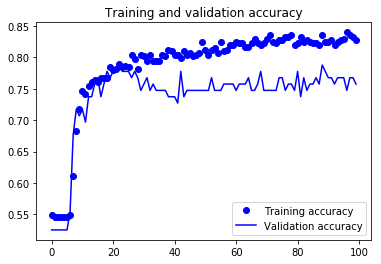

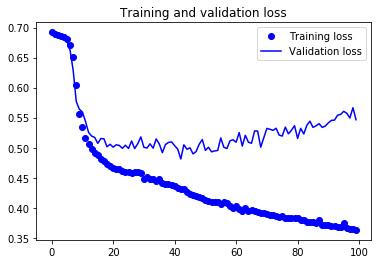

In [59]:
# Plot the training accuracy
accuracy = model_train.history['acc']
val_accuracy = model_train.history['val_acc']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()